# Import

In [1]:
import csv
import os
import pickle
import sys

import numpy as np
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from smart_open import open
from tqdm import tqdm

## Add configuration file

In [2]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")

In [3]:
from ALL import config 
from util import *

## Set condition

In [4]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [5]:
data_type="AgNews"

# Read data

In [6]:
df = pd.read_csv(
    f"../../Preprocessing/data/{data_type}/master.csv", index_col=0
)

In [7]:
with open(f"../../Preprocessing/data/{data_type}/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [8]:
class_num = config["data"][data_type]["class_num"]

In [9]:
label = df["class"].to_numpy()

In [10]:
class_labels[0]

['World', 'Sports', 'Business', 'SciTech']

In [11]:
document_topic = pd.read_csv(
    f"../../Preprocessing/data/{data_type}/GLDA/document_topic.txt",
    header=None,
    sep=" ",
)
document_topic = document_topic.drop(class_num, axis=1)

# Coherence

In [12]:
class Corpus:
    def __init__(self, path=None, texts=None):
        self.path = path
        self.texts = texts
        self.dictionary = Dictionary(texts)

    def __iter__(self):
        if self.path is not None:
            for line in open(self.path):
                # assume there's one document per line, tokens separated by whitespace
                yield self.dictionary.doc2bow(line.lower().split())
        else:
            for line in self.texts:
                yield self.dictionary.doc2bow(line)

In [13]:
texts = df.words_nonstop.progress_apply(
    lambda x: x.split(" ") if x is not np.nan else [""]
).tolist()
corpus = Corpus(texts=texts)
dictionary = Dictionary(texts)
#     登場頻度50%以上の単語を削除
dictionary.filter_extremes()

100%|██████████| 120000/120000 [00:00<00:00, 231254.11it/s]


In [14]:
pred = document_topic.idxmax(axis=1)

In [15]:
document_topic

,0,1,2,3
0,0.375000,0.375000,0.208333,0.041667
1,0.191176,0.485294,0.132353,0.191176
2,0.140625,0.578125,0.265625,0.015625
3,0.078125,0.703125,0.140625,0.078125
4,0.065789,0.592105,0.328947,0.013158
...,...,...,...,...
119995,0.291667,0.291667,0.347222,0.069444
119996,0.379630,0.231481,0.305556,0.083333
119997,0.163462,0.471154,0.240385,0.125000
119998,0.410714,0.315476,0.196429,0.077381


In [16]:
import matplotlib.pyplot as plt

(array([10329.,     0.,     0.,     0.,     0.,     0., 88457.,     0.,
            0.,     0.,     0.,     0.,     0., 17547.,     0.,     0.,
            0.,     0.,     0.,  3667.]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ]),
 <BarContainer object of 20 artists>)

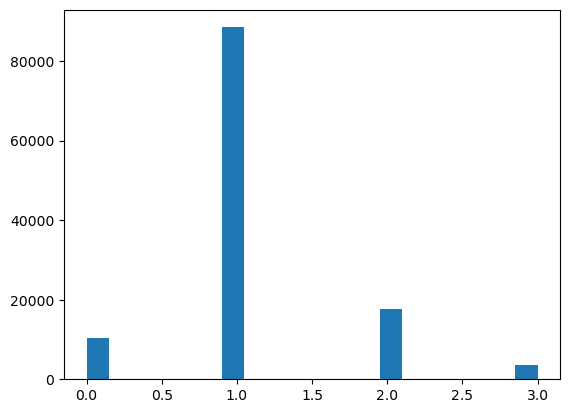

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(pred, bins=20)

In [18]:
cm = CoherenceModel(
    topics=pred.to_numpy().reshape(1, -1),
    corpus=corpus,
    dictionary=dictionary,
    texts=texts,
    coherence="c_v",
)
coherence_df = pd.DataFrame([cm.get_coherence()])

In [19]:
coherence_df

,0
0,0.997736


In [20]:
coherence_path = f"../data/{data_type}/GLDA/coherence.csv"
coherence_df.to_csv(make_filepath(coherence_path))